# DAGGER: An Online Imitation Learning Algorithm

<img src="https://raw.githubusercontent.com/FredAmouzgar/ImitationLearning/main/imgs/DAGGER.png" width=500>

Source: DAGGER paper <a href="https://arxiv.org/abs/1011.0686">A Reduction of Imitation Learning and Structured Prediction to No-Regret Online Learning</a>

## Defining the DAGGER agents' Neural Networks:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import numpy as np
import torch
import gym
import time, random
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLander-v2")
print(env.unwrapped, "environment started ...")

# reset the environment
state = env.reset()
print("Init state:", state)

# number of actions
action_size = env.action_space.n

# Init the state space and finding its size
state_size = env.observation_space.shape[0]

class Network(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Network, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Builds a network that maps state -> action values."""
        #pass
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class LearnerNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size): #, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(LearnerNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, state):
        """Builds a network that maps state -> action values."""
        #pass
        x = F.relu(self.fc1(state))
        return self.fc2(x)

<LunarLander<LunarLander-v2>> environment started ...
Init state: [-0.00459795  1.4153773  -0.46573418  0.19808556  0.00533464  0.10549586
  0.          0.        ]


## The Expert Class:

In [2]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # Agent's Network
        self.brain = Network(state_size, action_size).to(device)

    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.brain.eval()
        with torch.no_grad():
            action_values = self.brain(state)
        self.brain.train()

        action = np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
        action = np.int32(action)
        return action

## Loading the Expert and Initializing the Learner:

In [3]:
# Init our expert
expert = Agent(state_size=state_size, action_size=action_size)
# Loading expert's brain
expert.brain.load_state_dict(torch.load('LunarLander_Expert.pth'))
print("Expert loaded ...")

learner = LearnerNetwork(state_size=state_size, action_size=action_size).to(device)
print("Learner initialized ...")

Expert loaded ...
Learner initialized ...


## A function that tests an agent:

In [4]:
def test_agent(agent, env, epochs=1):
    max_t = 5000
    for i_episode in range(epochs):
        state = env.reset()
        score = 0
        for t in range(max_t):
            env.render()
            time.sleep(0.01)
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = agent(state)
            action = np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
            next_state, reward, done, _ = env.step(action)
            score += reward
            state = next_state
            if done:
                break
        #print(f"Score:{score}")
    time.sleep(1)
    env.close() # closing the environment
    return score

## Testing the Expert:

In [5]:
test_agent(agent=expert.brain, env=env, epochs=1)

271.59183570364365

## Testing the untrained agent:

In [6]:
test_agent(agent=learner, env=env, epochs=1)

-137.0171292740436

## Implementing DAGGER:
<img src="https://raw.githubusercontent.com/FredAmouzgar/ImitationLearning/main/imgs/DAGGER.png" width=500>

In [7]:
def train_learner(learner, X, y, optim):
    loss_fn = nn.CrossEntropyLoss()
    train_dataset = TensorDataset(X, y)
    loss_sum = 0
    dataloader = DataLoader(train_dataset, batch_size=64)
    for x_batch, y_batch in dataloader:
        predictions = learner(x_batch)
        loss = loss_fn(predictions, y_batch)
        loss_sum += loss
        optim.zero_grad()
        loss.backward()
        optim.step()
    #print("# LOSS:", loss_sum)
    return loss_sum

T = 5000  # @param: ['1000', '5000']
N = 20  # @param: ['20', '25']
Beta_base = 0.9  # @param: ['0.5', '0.9'] 
D_states = None
loss = 'Unknown'
testing_scores, losses = [], []
optimizer = torch.optim.Adam(learner.parameters(), lr=0.001)
episode_loop = tqdm(range(1, N + 1), desc="Episode 0 | Avg Score: None", leave=False)
for i in episode_loop:
    state = env.reset()
    score = 0
    Beta = Beta_base ** (i-1)
    #print("-----------------")
    #print("*** i:", i, "\t", "Beta:", Beta)
    episode_loop.set_description_str('Episode {} | Beta: {:.2f} | Training ...'.format(i, Beta))
    states = []
    for t in range(T):
        #env.render()
        states.append(state)
        if Beta >= random.uniform(0,1):
            expert_action = expert.act(state)
            action = expert_action
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            learner.eval()
            with torch.no_grad():
                action_values = learner(state)
            learner.train()
            action = np.argmax(action_values.cpu().data.numpy()).astype(np.int32)
            
        next_state, reward, done, _ = env.step(action)
        score += reward
        state = next_state
        if done:
            env.reset()
    states = torch.tensor(states).to(device)
    D_states = states if D_states==None else torch.cat([D_states, states])
    with torch.no_grad():
        D_actions = torch.argmax(expert.brain(D_states), dim=-1)
    loss = train_learner(learner, X=D_states, y=D_actions, optim=optimizer)
    losses.append(loss)
    #print(D_states.shape, D_actions.shape)
    #print(f"Score:{score}")
    episode_loop.set_description_str('Episode {} | Beta: {:.5f} | loss: {:.3f}| Testing ...'.format(i, Beta, loss))
    score = test_agent(agent=learner, env=env, epochs=1)
    testing_scores.append(score)
    episode_loop.set_description_str('Episode {} | Beta: {:.5f} | loss: {:.3f}| Test score: {:.3f}'.format(i, Beta, loss, score))
    time.sleep(2)
time.sleep(1)
torch.save(learner, "dagger_agent.pth")
env.close() # closing the environment

## Plotting the Loss and Testing Rewards:

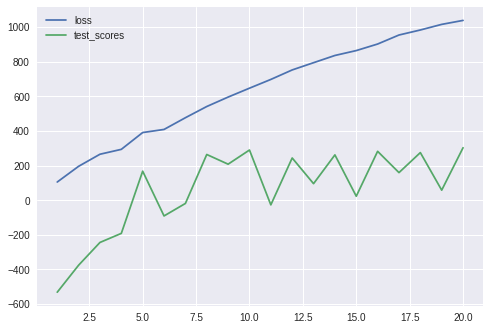

In [8]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

losses, testing_scores = np.array(losses), np.array(testing_scores)
plt.plot(range(1,len(losses)+1), losses, label="loss")
plt.plot(range(1,len(testing_scores)+1), testing_scores, label="test_scores")
plt.legend()
plt.show()

## The Final Performance of the Imitation Learning Agent:

In [10]:
learner = torch.load("dagger_agent.pth")
for _ in range(3):
    reward = test_agent(agent=learner, env=env)
    print(reward)

299.4762100465382
250.97276115556005
286.5677899781475


<hr>